In [183]:
from svdunfold import SVDunfold
import svdunfold
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
from matplotlib.colors import LogNorm
from scipy import stats
import random
from scipy.interpolate import interp1d

In [184]:
nevents=100000
x0 = 1836.4 # M2
gamma0 = 8.2
x1 =  2047 # M1
gamma1 = 14.49
mu = 0
N_detectors = 20
sigma=np.random.uniform(5,7,N_detectors)
gaussian_par=[mu,sigma]
cauchy_par_test_0=[x0,gamma0]
cauchy_par_test_1=[x1,gamma1]

cauchy_par_0=[x0-10,gamma0+4]
cauchy_par_1=[x1+20,gamma1-1]

x_min=1200
x_max=2700
x_nbins=100
b_min=1200
b_max=2700
b_nbins=100
#binwidth di 15 eV
nevents_test_1=np.random.randint(nevents-np.sqrt(nevents),nevents+np.sqrt(nevents),N_detectors)
nevents_test_0=np.random.randint(nevents-np.sqrt(nevents),nevents+np.sqrt(nevents),N_detectors)
def bins_and_centers(nbins, low, high):
    bins = np.linspace(low, high, nbins + 1)
    bin_centers = (bins + (bins[1] - bins[0]) / 2)[:-1]
    return bins, bin_centers


def add_smearing(x, n):
    smear = np.random.normal(gaussian_par[0],gaussian_par[1][n])
    return x + smear


def stddev(x_test,x,N):
    std_dev = []
    for i in range(N):
        temp = []
        for j in range(len(x[i])):
            temp.append(np.sqrt(np.sum((x_test[j]-x[i,j])**2)/(N))) #(len(x[i])-1)*
        std_dev.append(temp)
    std_dev = np.array(std_dev, dtype=float)
    return std_dev


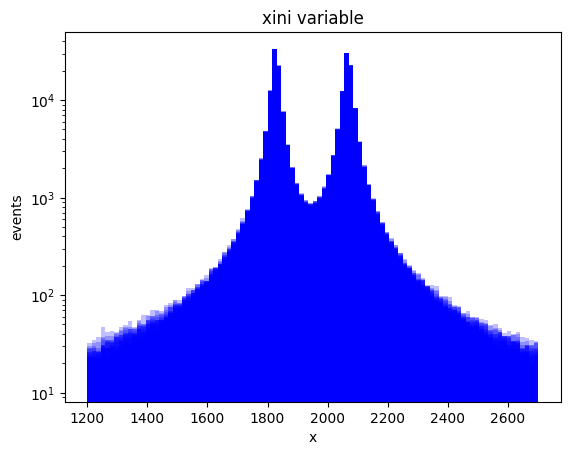

In [185]:

plt.figure(1)
xini_peak_0 = []
xini_peak_1 = []
for i in range(len(nevents_test_0)):
    xini_peak_0.append(stats.cauchy.rvs(cauchy_par_0[0], cauchy_par_0[1], nevents))
    xini_peak_1.append(stats.cauchy.rvs(cauchy_par_1[0], cauchy_par_1[1], nevents))
xini_peak_0 = np.array(xini_peak_0, dtype=object)
xini_peak_1 = np.array(xini_peak_1, dtype=object)
xini_peak = []
for i in range(len(nevents_test_0)):
    combined_row = np.concatenate((xini_peak_0[i], xini_peak_1[i]))
    xini_peak.append(combined_row)
xini_peak = np.array(xini_peak, dtype=object)
for i in range(len(nevents_test_0)):
    plt.hist(xini_peak[i], x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.25)
plt.title("xini variable")
plt.ylabel("events")
plt.xlabel("x")
plt.yscale("log")

(1200.0, 2700.0)

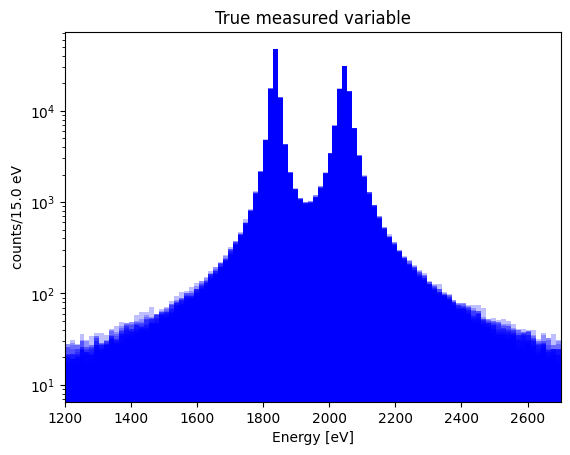

In [186]:
plt.figure(2)
xini_peak_test_0 = []
xini_peak_test_1 = []
for i in range(len(nevents_test_0)):
    xini_peak_test_0.append(stats.cauchy.rvs(cauchy_par_test_0[0], cauchy_par_test_0[1], nevents_test_0[i]))
    xini_peak_test_1.append(stats.cauchy.rvs(cauchy_par_test_1[0], cauchy_par_test_1[1], nevents_test_1[i]))
xini_peak_test_0 = np.array(xini_peak_test_0, dtype=object)
xini_peak_test_1 = np.array(xini_peak_test_1, dtype=object)
xini_peak_test = []
for i in range(len(nevents_test_0)):
    combined_row = np.concatenate((xini_peak_test_0[i], xini_peak_test_1[i]))
    xini_peak_test.append(combined_row)
xini_peak_test = np.array(xini_peak_test, dtype=object)
for i in range(len(nevents_test_0)):
    plt.hist(xini_peak_test[i], x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.25)
plt.title("True measured variable")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.xlabel("Energy [eV]")
plt.yscale("log")
plt.xlim(x_min,x_max)


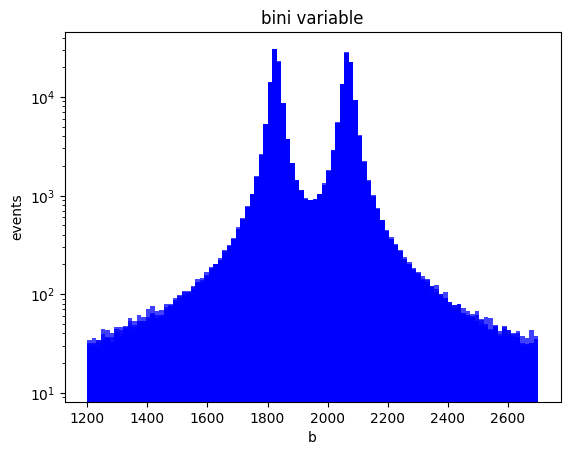

In [187]:

plt.figure(3)
b_ini_gen = []
for i in range(len(nevents_test_0)):
    b_ini_gen.append([add_smearing(x, i) for x in xini_peak[i]])

b_ini_gen = np.array(b_ini_gen, dtype=object)
for i in range(len(nevents_test_0)):
    plt.hist(b_ini_gen[i], x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.75)
plt.title("bini variable")
plt.ylabel("events")
plt.xlabel("b")
plt.yscale("log")


(1200.0, 2700.0)

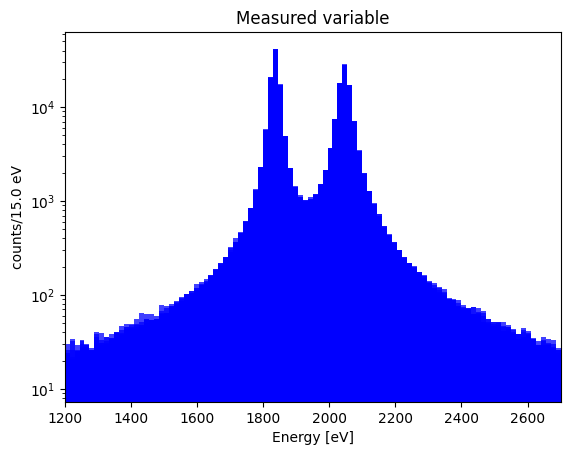

In [188]:

plt.figure(4)
b_test_gen = []
for i in range(len(nevents_test_0)):
    b_test_gen.append([add_smearing(x, i) for x in xini_peak_test[i]])

b_test_gen = np.array(b_test_gen, dtype=object)
for i in range(len(nevents_test_0)):
    plt.hist(b_test_gen[i], x_nbins, range=[x_min,x_max],histtype="stepfilled", color="blue", alpha=0.75)
plt.title("Measured variable")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.xlabel("Energy [eV]")
plt.yscale("log")
plt.xlim(x_min,x_max)

In [189]:
bins_x, bin_centers_x = bins_and_centers(x_nbins, x_min, x_max)
bins_b, bin_centers_b = bins_and_centers(b_nbins, b_min, b_max)
x_test_gen = xini_peak_test
x_ini_gen = xini_peak
x_ini = []
x_test = []
b_ini = []
b_test = []
scale_factor = []
for i in range(len(nevents_test_0)):
    x_ini.append(np.histogram(x_ini_gen[i], bins_x)[0])
    x_test.append(np.histogram(x_test_gen[i], bins_x)[0])
    scale_factor.append(len(x_test_gen[i])/len(x_ini_gen[i]))
    b_ini.append(np.histogram(b_ini_gen[i], bins_b)[0])
    b_test.append(np.histogram(b_test_gen[i], bins_b)[0])

b_ini = np.array(b_ini, dtype=float)
x_ini = np.array(x_ini, dtype=float)
x_test = np.array(x_test, dtype=float)
b_test = np.array(b_test, dtype=float)
b_test_err = []
for i in range(len(nevents_test_0)):
    b_test_err.append(np.sqrt(b_test[i][0]))
b_test_err = np.array(b_test_err, dtype=float)

In [190]:
def generate_response_matrix(x_ini_gen, b_ini_gen, bins_x,bins_b):
    return np.histogram2d(x_ini_gen, b_ini_gen, bins=[bins_x,bins_b])

A_matrix = []
X1 = []
for i in range(N_detectors):
    A_matrix.append(generate_response_matrix(x_ini_gen[i], b_ini_gen[i], bins_x,bins_b)[0].T)
    X1.append(np.sqrt(np.diag(A_matrix[i])))
    #plt.figure(7+i)
    #plt.imshow(A_matrix[i], norm=LogNorm(vmin=1, vmax=1e4), cmap="YlGnBu", extent=[bins_b[0], bins_b[-1],bins_b[-1],bins_b[0]])
A_matrix = np.array(A_matrix, dtype=float)
X1 = np.array(X1, dtype=float)

In [191]:
def diagonal_covariance(b, nb, b_min, b_max):
    data = np.histogram(b, bins=nb, range=(b_min, b_max))[0]
    B = np.zeros(shape=(nb,nb))
    std_dev = np.sqrt(data)
    for i in range(nb):
        B[i, i] = std_dev[i] * std_dev[i] #indipendent bin values
    return B
B = []
for i in range(N_detectors):
    B.append(diagonal_covariance(b_test_gen[i], b_nbins, b_min, b_max))
B = np.array(B, dtype=float)

In [192]:
unfold = []
for i in range(N_detectors):
    unfold.append(svdunfold.SVDunfold(x_ini[i], b_test[i], A_matrix[i], B[i], x_min,x_max,b_min,b_max, 0.001))
    unfold[i].pre_unfolding()

chi2 = []
kk = []
min_k = np.full(N_detectors, -1)
minn = np.full(N_detectors, np.inf)

for k in range(x_nbins):
    for i in range(N_detectors):
        unfold[i].unfolding(k)
        kk.append(k)
        x = unfold[i].get_x_unfolded()
        X = unfold[i].get_X_unfolded_covariance()
        a = np.sum(((x - x_test[i])**2) / np.sqrt(np.diag(X)))
        chi2.append(a)
        
        if minn[i] > a:
            minn[i] = a
            min_k[i] = k
for i in range(N_detectors):
    if min_k[i]>50:
        print(f"Controlla N detector {i}")
        min_k[i]=30
print(min_k)

Controlla N detector 1
Controlla N detector 11
Controlla N detector 15
Controlla N detector 16
Controlla N detector 19
[25 30 27 26 26 35 27 23 22 31 31 30 29 26 26 30 30 23 27 30]


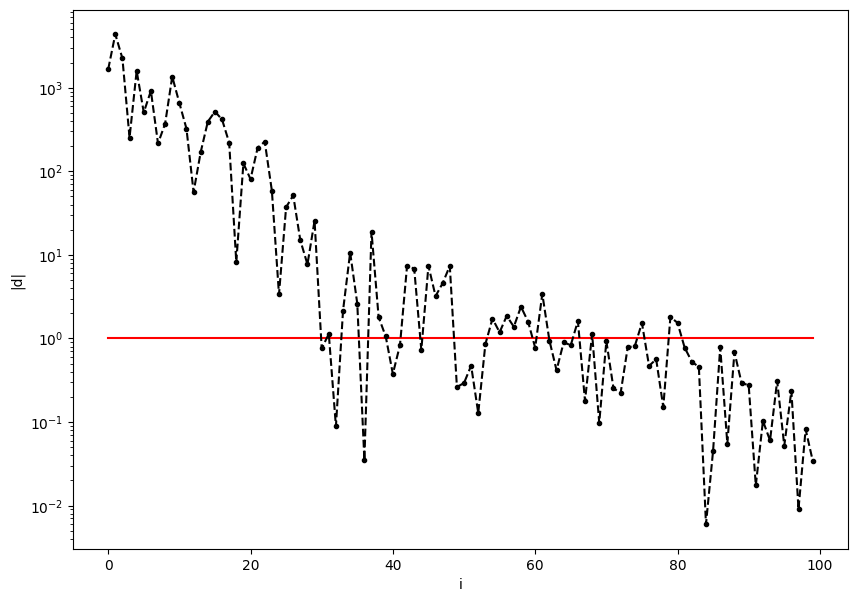

In [193]:
d=[]
for i in range(N_detectors):
    d.append(unfold[i].get_abs_d())

plt.figure(figsize=(10, 7))

plt.plot(np.arange(len(d[0])), np.ones(len(d[0])), "r-" )
plt.plot(np.arange(len(d[0])), d[0], "k.--")
plt.xlabel("i")
plt.ylabel("|d|")
plt.yscale("log")



In [194]:
x = []
err = []
X = []
for i in range(N_detectors):
    unfold[i].unfolding(min_k[i])  # Chiama il metodo unfolding
    x.append(unfold[i].get_x_unfolded())
    X.append(unfold[i].get_X_unfolded_covariance())
    err.append(np.sqrt(np.diag(X[i])))

[0.63797221 0.61959924 0.5818549  0.65822285 0.57040318 0.6223177
 0.56982878 0.56721241 0.59106832 0.540194   0.55686408 0.57552716
 0.55657676 0.597194   0.59316676 0.5636387  0.60229479 0.6202471
 0.66052452 0.67760574 0.66315681 0.70986943 0.70173162 0.71214016
 0.74289252 0.75105286 0.75513473 0.81382877 0.81231536 0.83274519
 0.87592157 0.90291204 0.9441831  1.02235755 1.10579315 1.21947792
 1.30759833 1.42496592 1.8737336  2.50049987 3.29004051 3.96834734
 4.31301371 2.80014079 2.19132088 1.66322309 1.4617691  1.28826918
 1.18374047 1.16489053 1.2379752  1.26237477 1.30377679 1.51637516
 1.91922776 2.44246207 3.1386071  3.84159557 3.17115014 2.38052816
 2.11402194 1.74373977 1.51626909 1.28769399 1.13097118 1.02481458
 0.91533121 0.87467691 0.83387942 0.78161059 0.73950394 0.7231796
 0.66074348 0.62743078 0.61055388 0.60768948 0.57847793 0.54966783
 0.53921208 0.52302386 0.49969174 0.4892217  0.49956848 0.46540021
 0.44215409 0.44329138 0.45807448 0.4250715  0.40467994 0.4053515

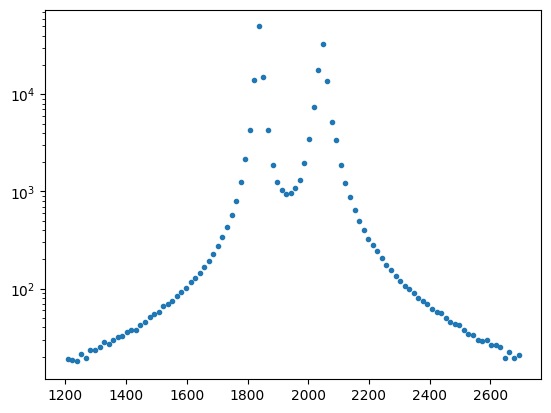

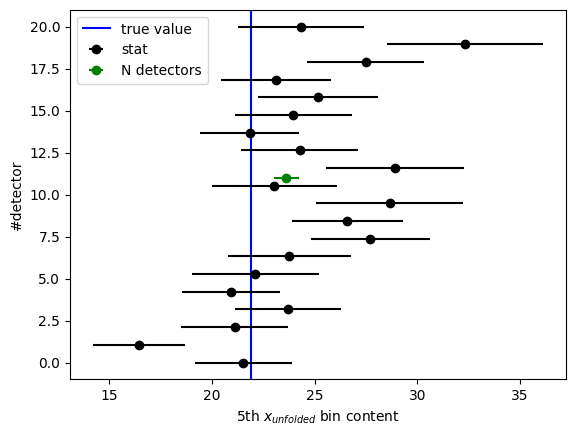

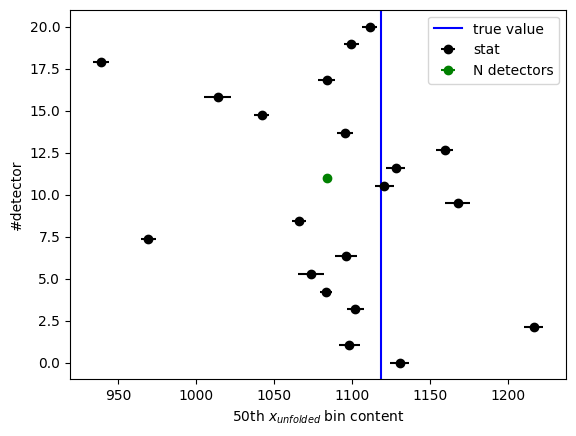

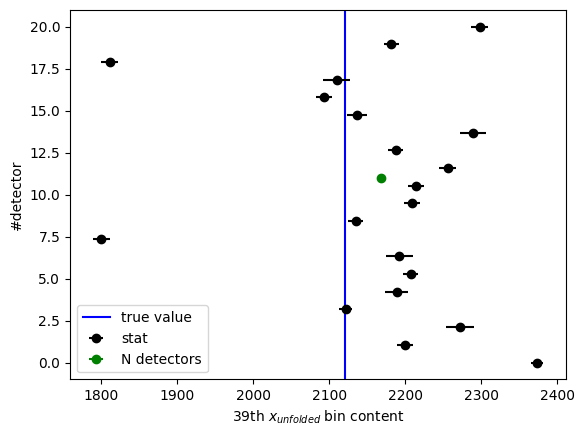

In [195]:
x = np.array(x, dtype=float)
err = np.array(err, dtype=float)
err_plus_sys = err
N_d = np.linspace(0, N_detectors, N_detectors)

b_final_test = np.mean(b_test, axis=0)
x_final_test = np.mean(x_test, axis=0)

plt.figure(2)
weights = 1 / (err_plus_sys ** 2)
denominator = np.sum(weights, axis=0)
numerator = np.sum((x * weights), axis=0)
x_final = numerator / denominator
error_tot = np.sqrt(1./denominator)
print(error_tot)

plt.errorbar(bin_centers_x,x_final, marker=".", yerr=error_tot, linestyle="")
plt.yscale("log")
plt.figure(66)
plt.axvline(x=x_final_test[5], color='b', label='true value')
#plt.errorbar(x[:,5],N_d, xerr=err_plus_sys[:,5], linestyle="", marker="o", color="red", label="sys+stat")
plt.errorbar(x[:,5],N_d, xerr=err[:,5], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[5],11, xerr=error_tot[5], linestyle="", marker="o", color="green", label="N detectors")

plt.legend()
plt.xlabel("5th $x_{unfolded}$ bin content")
plt.ylabel("#detector")
plt.savefig("/home/sara/Downloads/svdunfold_5th_bin.png")
plt.figure(67)
plt.axvline(x=x_final_test[50], color='b', label='true value')
#plt.errorbar(x[:,50],N_d, xerr=err_plus_sys[:,50], linestyle="", marker="o", color="red", label="sys+stat")
plt.errorbar(x[:,50],N_d, xerr=err[:,50], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[50],11, xerr=error_tot[50], linestyle="", marker="o", color="green", label="N detectors")

plt.xlabel("50th $x_{unfolded}$ bin content")
plt.ylabel("#detector")
plt.legend()
plt.savefig("/home/sara/Downloads/svdunfold_50th_bin.png")
plt.figure(68)
d=39
plt.axvline(x=x_final_test[d], color='b', label='true value')
#plt.errorbar(x[:,d],N_d, xerr=err_plus_sys[:,d], linestyle="", marker="o", color="red", label="sys+stat")
plt.errorbar(x[:,d],N_d, xerr=err[:,d], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[d],11, xerr=error_tot[d], linestyle="", marker="o", color="green", label="N detectors")
plt.xlabel("39th $x_{unfolded}$ bin content")
plt.ylabel("#detector")
plt.legend() 
plt.savefig("/home/sara/Downloads/svdunfold_39th_bin.png")

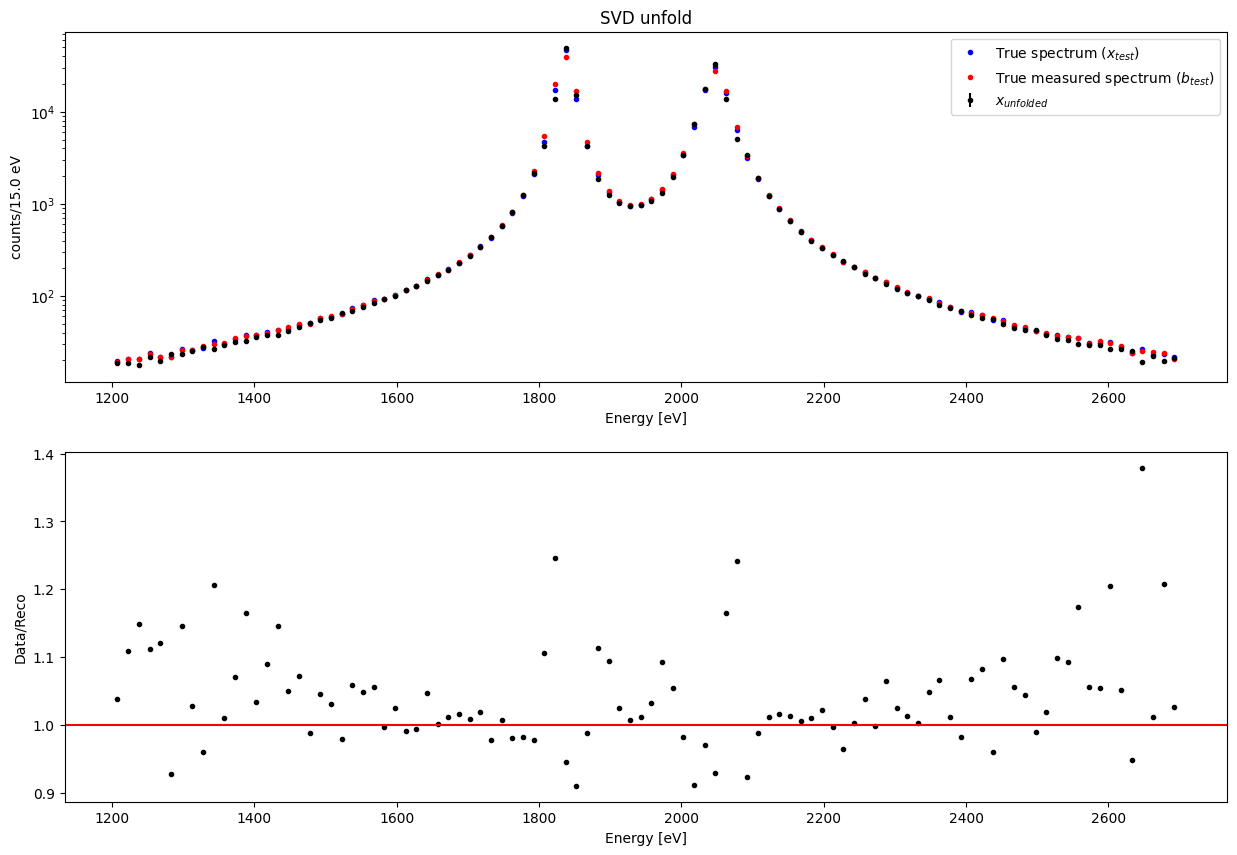

In [196]:
plt.subplots(2 , 1, figsize=(15, 10))
plt.subplot(2,1,1)
plt.plot(bin_centers_x, x_final_test, ".", color="blue", label="True spectrum ($x_{test}$)")
plt.plot(bin_centers_b, b_final_test, ".", color="red", label="True measured spectrum ($b_{test}$)")
plt.title("SVD unfold")

plt.errorbar(bin_centers_x, x_final, yerr=error_tot, label="$x_{unfolded}$" , marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.legend()
plt.yscale("log")
plt.subplot(2,1,2)
plt.plot(bin_centers_x,(x_final_test/x_final), marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("Data/Reco")
plt.axhline(y=1, color="red")
plt.savefig("/home/sara/Downloads/svdunfold_20detector.png")

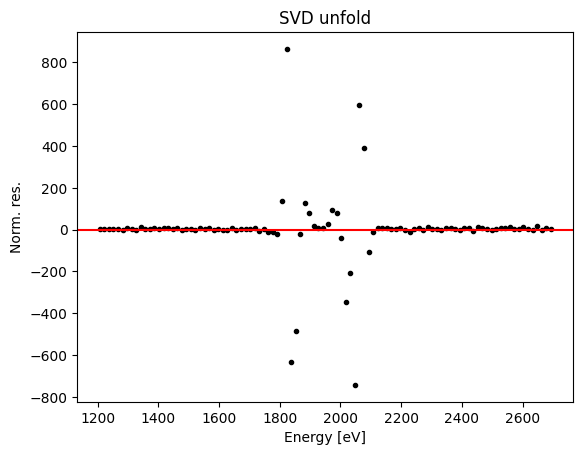

In [197]:
plt.figure(25)
plt.title("SVD unfold")

plt.xlabel("Energy [eV]")
plt.plot(bin_centers_x,(x_final_test-x_final)/error_tot, marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("Norm. res.")
plt.axhline(y=0, color="red")
plt.savefig("/home/sara/Downloads/svdunfold_bias_20dec.png")
plt.show()

## Sistematiche 

In [198]:
plt.figure(1)
xini_peak_0_p = []
xini_peak_1_p = []
xini_peak_0_m = []
xini_peak_1_m = []
for i in range(len(nevents_test_0)):
    xini_peak_0_p.append(stats.cauchy.rvs(cauchy_par_0[0], cauchy_par_0[1], nevents+5*int(np.sqrt(nevents))))
    xini_peak_1_p.append(stats.cauchy.rvs(cauchy_par_1[0], cauchy_par_1[1], nevents+5*int(np.sqrt(nevents))))
    xini_peak_0_m.append(stats.cauchy.rvs(cauchy_par_0[0], cauchy_par_0[1], nevents-5*int(np.sqrt(nevents))))
    xini_peak_1_m.append(stats.cauchy.rvs(cauchy_par_1[0], cauchy_par_1[1], nevents-5*int(np.sqrt(nevents))))
xini_peak_0_p = np.array(xini_peak_0_p, dtype=object)
xini_peak_1_p = np.array(xini_peak_1_p, dtype=object)
xini_peak_0_m = np.array(xini_peak_0_m, dtype=object)
xini_peak_1_m = np.array(xini_peak_1_m, dtype=object)
xini_peak_p = []
xini_peak_m = []

for i in range(len(nevents_test_0)):
    combined_row_p = np.concatenate((xini_peak_0_p[i], xini_peak_1_p[i]))
    combined_row_m = np.concatenate((xini_peak_0_m[i], xini_peak_1_m[i]))

    xini_peak_p.append(combined_row_p)
    xini_peak_m.append(combined_row_m)

xini_peak_p = np.array(xini_peak_p, dtype=object)
xini_peak_m = np.array(xini_peak_m, dtype=object)
x_ini_gen_p = xini_peak_p 
x_ini_gen_m = xini_peak_m

<Figure size 640x480 with 0 Axes>

In [199]:
plt.figure(3)
b_ini_gen_p = []
b_ini_gen_m = []

for i in range(len(nevents_test_0)):
    b_ini_gen_p.append([add_smearing(x, i) for x in xini_peak_p[i]])
    b_ini_gen_m.append([add_smearing(x, i) for x in xini_peak_m[i]])

b_ini_gen_p = np.array(b_ini_gen_p, dtype=object)
b_ini_gen_m = np.array(b_ini_gen_m, dtype=object)

<Figure size 640x480 with 0 Axes>

In [200]:
A_matrix_p = []
A_matrix_m = []
B_p = []
B_m = []
for i in range(N_detectors):
    A_matrix_p.append(generate_response_matrix(x_ini_gen_p[i], b_ini_gen_p[i], bins_x,bins_b)[0].T)
    A_matrix_m.append(generate_response_matrix(x_ini_gen_m[i], b_ini_gen_m[i], bins_x,bins_b)[0].T)

A_matrix_p = np.array(A_matrix_p, dtype=float)
A_matrix_m = np.array(A_matrix_m, dtype=float)

In [201]:
unfold_p = []
unfold_m = []

for i in range(N_detectors):
    unfold_p.append(svdunfold.SVDunfold(x_ini[i], b_test[i], A_matrix_p[i], B[i], x_min,x_max,b_min,b_max, 0.001))
    unfold_m.append(svdunfold.SVDunfold(x_ini[i], b_test[i], A_matrix_m[i], B[i], x_min,x_max,b_min,b_max, 0.001))
    unfold_m[i].pre_unfolding()
    unfold_p[i].pre_unfolding()

chi2_p = []
kk_p = []
min_k_p = np.full(N_detectors, -1)
minn_p = np.full(N_detectors, np.inf)

chi2_m = []
kk_m = []
min_k_m = np.full(N_detectors, -1)
minn_m = np.full(N_detectors, np.inf)


for k_p in range(x_nbins):
    for i in range(N_detectors):
        unfold_p[i].unfolding(k_p)
        kk_p.append(k_p)
        x_p = unfold_p[i].get_x_unfolded()
        X_p = unfold_p[i].get_X_unfolded_covariance()
        a_p = np.sum(((x_p - x_test[i])**2) / np.sqrt(np.diag(X_p)))
        chi2_p.append(a_p)
        
        if minn_p[i] > a_p:
            minn_p[i] = a_p
            min_k_p[i] = k_p

for k_m in range(x_nbins):
    for i in range(N_detectors):
        unfold_m[i].unfolding(k_m)
        kk_m.append(k_m)
        x_m = unfold_m[i].get_x_unfolded()
        X_m = unfold_m[i].get_X_unfolded_covariance()
        a_m = np.sum(((x_m - x_test[i])**2) / np.sqrt(np.diag(X_m)))
        chi2_m.append(a_m)
        
        if minn_m[i] > a_m:
            minn_m[i] = a_m
            min_k_m[i] = k_m

for i in range(N_detectors):
    if min_k_p[i]>50:
        print(f"Controlla N detector p {i}")
        min_k_p[i]=30
    if min_k_m[i]>50:
        print(f"Controlla N detector m {i}")
        min_k_m[i]=30

Controlla N detector p 1
Controlla N detector m 1
Controlla N detector m 5
Controlla N detector m 10
Controlla N detector p 11
Controlla N detector m 11
Controlla N detector p 15
Controlla N detector m 15
Controlla N detector p 16
Controlla N detector m 16
Controlla N detector p 19
Controlla N detector m 19


In [202]:
x_p = []
err_p = []
X_p = []
x_m = []
err_m = []
X_m = []
for i in range(N_detectors):
    unfold_p[i].unfolding(min_k_p[i])  
    unfold_m[i].unfolding(min_k_m[i])  
    x_p.append(unfold_p[i].get_x_unfolded())
    X_p.append(unfold_p[i].get_X_unfolded_covariance())
    x_m.append(unfold_m[i].get_x_unfolded())
    X_m.append(unfold_m[i].get_X_unfolded_covariance())
    err_p.append(np.sqrt(np.diag(X_p[i])))
    err_m.append(np.sqrt(np.diag(X_m[i])))

In [203]:
x_p = np.array(x_p, dtype=float)
err_p = np.array(err_p, dtype=float)
err_plus_sys_p = err_p
x_m = np.array(x_m, dtype=float)
err_m = np.array(err_m, dtype=float)
err_plus_sys_m = err_m

weights = 1 / (err_plus_sys_p ** 2)
denominator = np.sum(weights, axis=0)
numerator = np.sum((x_p * weights), axis=0)
x_final_p = numerator / denominator
error_tot_p = np.sqrt(1./denominator)

weights = 1 / (err_plus_sys_m** 2)
denominator = np.sum(weights, axis=0)
numerator = np.sum((x_m * weights), axis=0)
x_final_m = numerator / denominator
error_tot_m = np.sqrt(1./denominator)

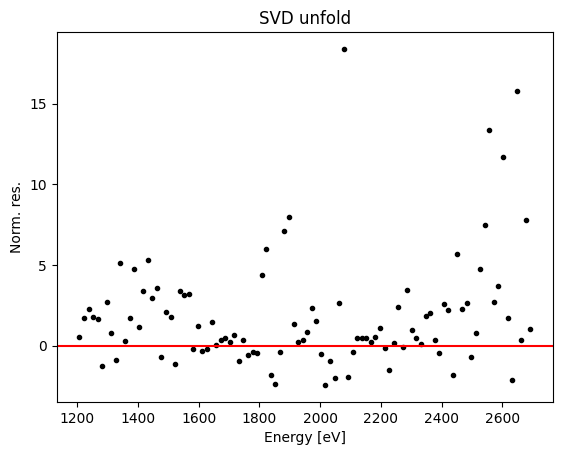

In [204]:
error_tot= np.sqrt((x_final_p-x_final_m)**2+error_tot**2)
plt.figure(25)
plt.title("SVD unfold")

plt.xlabel("Energy [eV]")
plt.plot(bin_centers_x,(x_final_test-x_final)/error_tot, marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("Norm. res.")

plt.axhline(y=0, color="red")
plt.savefig("/home/sara/Downloads/svdunfold_bias_20dec_corretto.png")



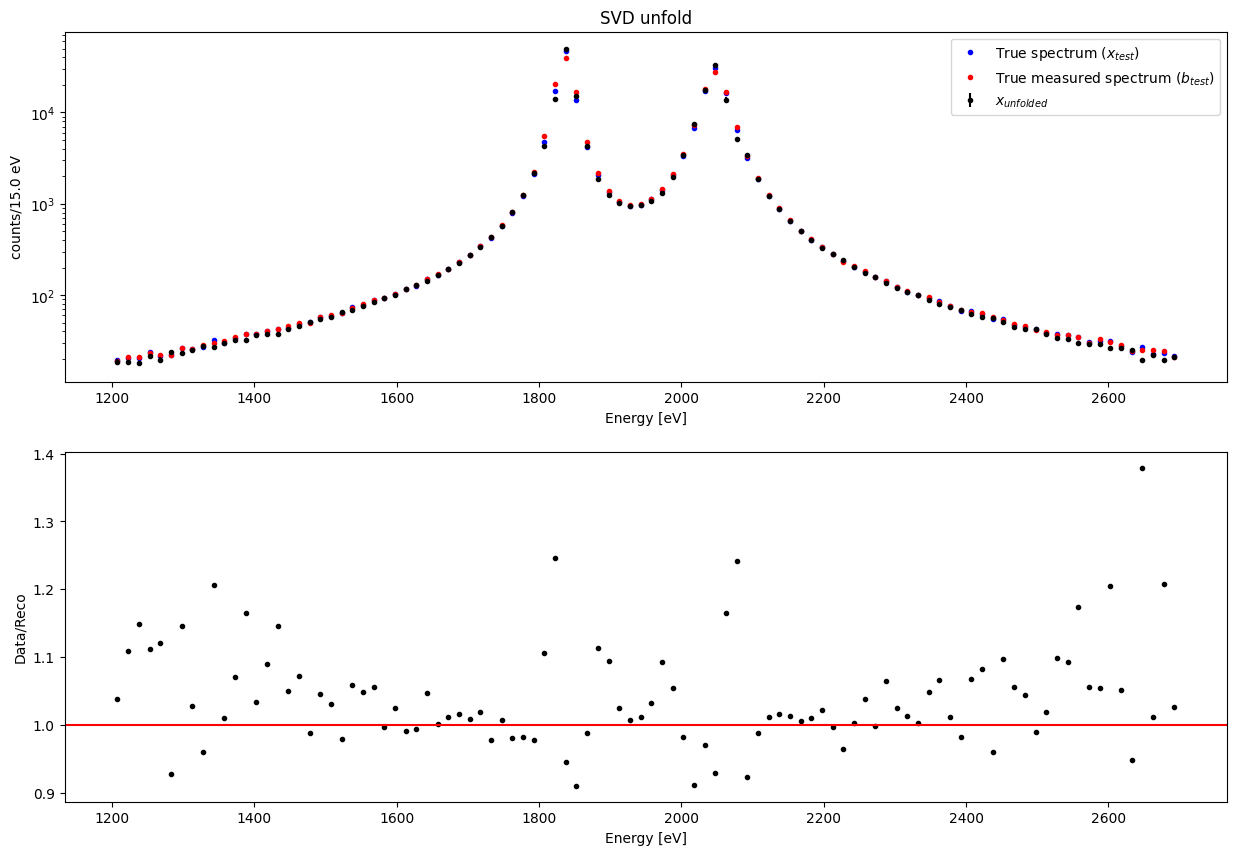

In [205]:
plt.subplots(2 , 1, figsize=(15, 10))
plt.subplot(2,1,1)
plt.plot(bin_centers_x, x_final_test, ".", color="blue", label="True spectrum ($x_{test}$)")
plt.plot(bin_centers_b, b_final_test, ".", color="red", label="True measured spectrum ($b_{test}$)")
plt.title("SVD unfold")

plt.errorbar(bin_centers_x, x_final, yerr=error_tot, label="$x_{unfolded}$" , marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("counts/{} eV".format((x_max-x_min)/x_nbins))
plt.legend()
plt.yscale("log")
plt.subplot(2,1,2)
plt.plot(bin_centers_x,(x_final_test/x_final), marker='.', linestyle="", color="black")
plt.xlabel("Energy [eV]")
plt.ylabel("Data/Reco")
plt.axhline(y=1, color="red")

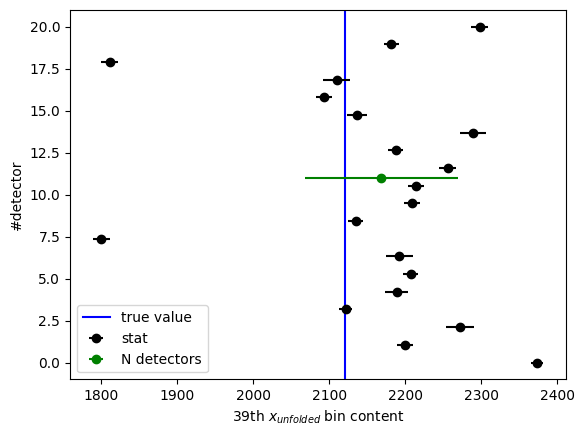

In [206]:
plt.figure(68)
d=39
plt.axvline(x=x_final_test[d], color='b', label='true value')
#plt.errorbar(x[:,d],N_d, xerr=err_plus_sys[:,d], linestyle="", marker="o", color="red", label="sys+stat")
plt.errorbar(x[:,d],N_d, xerr=err[:,d], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[d],11, xerr=error_tot[d], linestyle="", marker="o", color="green", label="N detectors")
plt.xlabel("39th $x_{unfolded}$ bin content")
plt.ylabel("#detector")
plt.legend() 
plt.savefig("/home/sara/Downloads/svdunfold_39th_bin_reg.png")

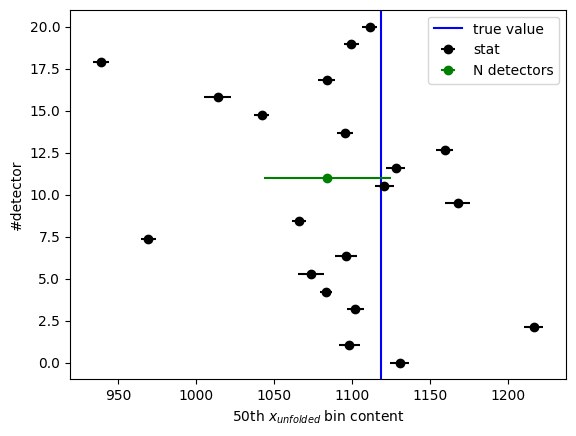

In [207]:
plt.figure(68)
d=50
plt.axvline(x=x_final_test[d], color='b', label='true value')
#plt.errorbar(x[:,d],N_d, xerr=err_plus_sys[:,d], linestyle="", marker="o", color="red", label="sys+stat")
plt.errorbar(x[:,d],N_d, xerr=err[:,d], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[d],11, xerr=error_tot[d], linestyle="", marker="o", color="green", label="N detectors")
plt.xlabel("50th $x_{unfolded}$ bin content")
plt.ylabel("#detector")
plt.legend() 
plt.savefig("/home/sara/Downloads/svdunfold_50th_bin.png")

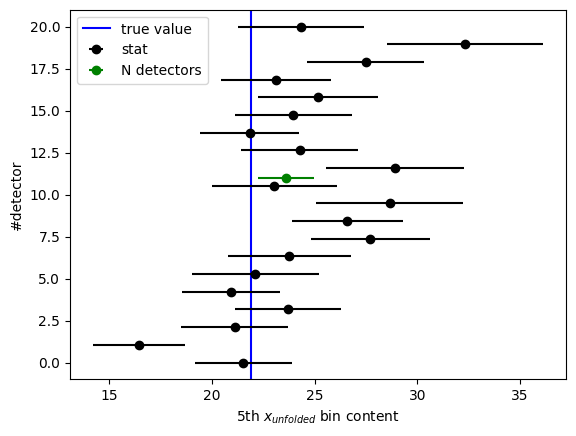

In [208]:
plt.figure(68)
d=5
plt.axvline(x=x_final_test[d], color='b', label='true value')
#plt.errorbar(x[:,d],N_d, xerr=err_plus_sys[:,d], linestyle="", marker="o", color="red", label="sys+stat")
plt.errorbar(x[:,d],N_d, xerr=err[:,d], linestyle="", marker="o", color="black", label="stat")
plt.errorbar(x_final[d],11, xerr=error_tot[d], linestyle="", marker="o", color="green", label="N detectors")
plt.xlabel("5th $x_{unfolded}$ bin content")
plt.ylabel("#detector")
plt.legend() 
plt.savefig("/home/sara/Downloads/svdunfold_5th_bin.png")